# Modeling Pipeline
## Stroke Risk Prediction

This notebook implements a reproducible machine learning pipeline for stroke risk prediction.

Objectives:
- Prevent data leakage via proper train/test separation
- Build a structured preprocessing pipeline
- Train a Logistic Regression baseline model
- Evaluate performance using discrimination and threshold analysis
- Perform cost-sensitive threshold optimization


## 1. Imports


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
    precision_score,
    recall_score
)

## 2. Data Loading


In [5]:
# Load dataset
df = pd.read_csv("../data/raw/healthcare-dataset-stroke-data.csv")

# Create BMI missingness indicator (binary)
df["bmi_missing"] = df["bmi"].isna().astype(int)

# Define predictors (X) and target (y)
X = df.drop(columns=["id", "stroke"])
y = df["stroke"]

## 3. Train-Test Split

Data is split before any preprocessing to prevent data leakage.
Stratified sampling preserves class imbalance across sets.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

## 4. Feature Grouping


In [9]:
numeric_cols = ["age", "avg_glucose_level", "bmi"]
binary_cols = ["hypertension", "heart_disease", "bmi_missing"]
categorical_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

## 5. Preprocessing Pipeline

- Numeric: median imputation + standardization
- Binary: passthrough
- Categorical: one-hot encoding (drop first to avoid multicollinearity)


In [11]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = OneHotEncoder(
    drop="first",
    handle_unknown="ignore"
)

column_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("bin", "passthrough", binary_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

## 6. Logistic Regression Model


In [13]:
logreg_pipeline = Pipeline(steps=[
    ("preprocessing", column_transformer),
    ("model", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ))
])

logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('bin', 'passthrough',
                                                  ['hypertension',
                                                   'heart_disease',
                                                   'bmi_missing']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

## 7. Model Evaluation


In [15]:
# Predicted probabilities for positive class
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")

ROC-AUC: 0.843


### Precision-Recall Analysis


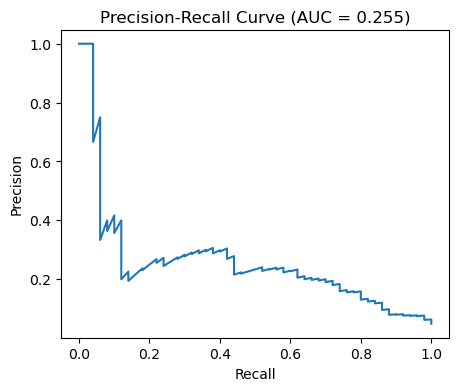

PR-AUC: 0.255


<Figure size 640x480 with 0 Axes>

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(5,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AUC = {pr_auc:.3f})")
plt.show()
plt.savefig("pr_curve_auc.png")
print(f"PR-AUC: {pr_auc:.3f}")

## 8. Cost-Sensitive Threshold Optimization

Thresholds are selected under varying false-negative to false-positive cost ratios.


In [19]:
cost_ratios = [2, 5, 10]
thresholds = np.linspace(0.0, 1.0, 201)

results = []

for ratio in cost_ratios:
    best_cost = np.inf
    best_threshold = None
    
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
        
        total_cost = fn * ratio + fp
        
        if total_cost < best_cost:
            best_cost = total_cost
            best_threshold = t
    
    results.append((ratio, best_threshold, best_cost))

results

[(2, 0.9550000000000001, 95), (5, 0.8250000000000001, 196), (10, 0.68, 290)]

## 9. Calibration Analysis

Discrimination metrics (ROC-AUC / PR-AUC) evaluate ranking ability.
Calibration evaluates whether predicted probabilities reflect true event frequencies.

A well-calibrated model produces probabilities that match observed outcome rates.


Brier Score: 0.1600


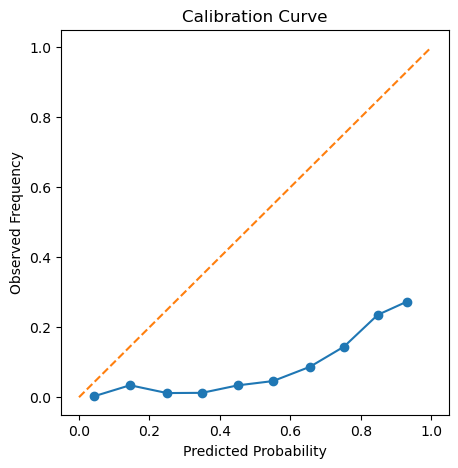

<Figure size 640x480 with 0 Axes>

In [40]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

# Brier Score (overall probability accuracy)
brier = brier_score_loss(y_test, y_proba)
print(f"Brier Score: {brier:.4f}")

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve")
plt.show()
plt.savefig("calibration_curve.png")

### Calibration Interpretation

The calibration curve indicates that the model systematically **overestimates risk**, particularly at higher predicted probabilities. 

While discrimination performance (ROC-AUC / PR-AUC) is strong, the predicted probabilities do not closely match observed event frequencies. This suggests the model is better suited for **risk ranking** than for direct probability interpretation.

In operational settings, this would require:
- Probability recalibration (e.g., Platt scaling or isotonic regression), or
- Careful threshold selection based on observed performance rather than raw probability values.

This highlights the importance of evaluating both discrimination and calibration when deploying probabilistic models.

## 10. Conclusion

This project demonstrates the development of a decision-aware probabilistic risk scoring model with emphasis on methodological rigor and operational interpretability.

Key components implemented:

- Leakage-safe preprocessing pipeline embedded within a reproducible modeling framework
- Logistic Regression baseline with class imbalance handling
- Discrimination evaluation using ROC-AUC and Precision–Recall metrics
- Cost-sensitive threshold optimization under multiple FN:FP trade-off scenarios
- Calibration analysis to assess probability reliability

Results show strong discrimination performance, indicating effective risk ranking capability. However, calibration analysis reveals systematic overestimation of predicted probabilities, particularly at higher risk levels. This highlights the distinction between ranking performance and probability reliability.

Rather than treating classification as a fixed 0.5-threshold problem, the model was explicitly framed as a **risk scoring engine**, where operating thresholds are selected based on operational priorities and acceptable trade-offs.

While the pipeline demonstrates strong methodological foundations, further steps such as probability recalibration, external validation, and prospective evaluation would be required before real-world deployment.

This work illustrates how predictive modeling, when combined with decision-aware evaluation, can move from pure modeling toward structured risk-informed decision systems.